## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [73]:
df= pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [74]:
nbr_rows = df.shape[0]
nbr_rows

294478

c. The number of unique users in the dataset.

In [75]:
nbr_uu = len(df['user_id'].unique())
nbr_uu

290584

d. The proportion of users converted.

In [76]:
uu = list(df["user_id"].unique())
df_uu = df.query('user_id == @uu')
p = df_uu['converted'].sum()/nbr_uu
p

0.12126269856564711

e. The number of times the `new_page` and `treatment` don't match.

In [77]:
n = df.query('group=="control" & landing_page=="new_page"').shape[0] + df.query('group=="treatment" & landing_page=="old_page"').shape[0]
n

3893

f. Do any of the rows have missing values?

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page. 

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [79]:
df2 = df.copy()
to_remove = df2.query('(group=="treatment" & landing_page=="old_page") | (group=="control" & landing_page=="new_page")')
df2.drop(to_remove.index, inplace = True)

In [80]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

3.a. How many unique **user_id**s are in **df2**?

In [81]:
uu = df2['user_id'].unique().shape[0]
uu

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [82]:
df2[df2['user_id'].duplicated()].iloc[0,0]

773192

c. What is the row information for the repeat **user_id**? 

In [83]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [84]:
df2.drop_duplicates('user_id',keep='first',inplace=True)
df2.shape

(290584, 5)

`4.`a. What is the probability of an individual converting regardless of the page they receive?

In [85]:
df2['converted'].sum()/uu

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [86]:
p_control = df2[df2['group']=='control']['converted'].sum()/df2[df2['group']=='control'].shape[0]
p_control

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [87]:
p_treatment = df2.query('group=="treatment"')['converted'].sum()/df2[df2['group']=='treatment'].shape[0]
p_treatment

0.11880806551510564

d. What is the probability that an individual received the new page?

In [88]:
df2.query('landing_page=="new_page"').shape[0]/uu

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**Answer:**

The informations we have up to this point indicates that a certain individual has 50% chance to either be selected to join the 'control' or 'treatment' group. This unbaised selection process makes it possible to compare the calculated rates directly.

The conversion rates of the two groups are; 11.88% conversion rate for the 'treatment' group, and 12.04% for the control group. Since the difference in conversion rate is about 0.16%, we can not decide directly whether it is significant or no. Thus, we need to invistigate the statistical significane of this difference more using the A/B testing and the p-value.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Put your answer here.**

$$ H_0 = p_{new}-p_{old}\leq 0$$
$$ H_1 = p_{new}-p_{old}> 0$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [89]:
p_new = df2['converted'].sum()/uu
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [90]:
p_old = df2['converted'].sum()/uu
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [91]:
n_new = df2[df2['group']=='treatment'].shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [92]:
n_old = df2[df2['group']=='control'].shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [93]:
new_page_converted = np.random.binomial(1, p_new, size=n_new)
new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [94]:
old_page_converted = np.random.binomial(1, p_old, size=n_old)
old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [95]:
p_new_simu=new_page_converted.sum()/new_page_converted.shape[0]
p_old_simu=old_page_converted.sum()/old_page_converted.shape[0]
p_new_simu-p_old_simu

-7.0897994565735645e-05

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [96]:
p_diffs=[]
for item in range(10000):
    temp_new = np.random.binomial(1, p_new, size=n_new)
    temp_old = np.random.binomial(1, p_old, size=n_old)
    temp_p_new = temp_new.sum()/temp_new.shape[0]
    temp_p_old = temp_old.sum()/temp_old.shape[0]
    p_diffs.append(temp_p_new-temp_p_old)
p_diffs=np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

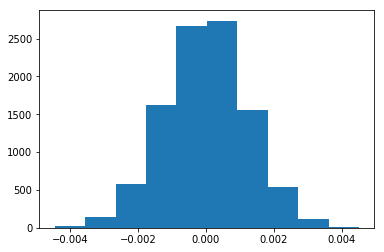

In [97]:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [98]:
actual_diff = p_treatment-p_control
p_val = (p_diffs > actual_diff).mean()
p_val

0.90310000000000001

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**َAnswer:**

The proportion of the **p_diffs** that is greater than the actual difference observed in **ab_data.csv** is called the **p-value**.

This value is always between 0 and 1 and in this case it represents the statistical significance of the difference between the responses related to the old page versus the new page. 

Since the p value we have got is 0.911 which is very close to 1, then we can conclude that the difference **$p_{new}-p_{old}$** is not statistically significant. 


l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [99]:
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest
convert_old = df2[df2['group']=='control']['converted'].sum()/df2[df2['group']=='control'].shape[0]
convert_new = df2[df2['group']=='treatment']['converted'].sum()/df2[df2['group']=='treatment'].shape[0]
n_old = df2[df2['group']=='control'].shape[0]
n_new = df2[df2['group']=='treatment'].shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [100]:
nbr_success_old = df2[df2['group']=='control']['converted'].sum()
nbr_success_new = df2[df2['group']=='treatment']['converted'].sum()
count = np.array([nbr_success_new , nbr_success_old])
nobs = np.array([n_new , n_old])
z_score , pval=proportions_ztest(count,nobs,0,'larger')
pval, z_score

(0.90505831275902449, -1.3109241984234394)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Answer**

The calculated p-value 0.905 using the ztest method agrees with the p-value calculated in the question **j** which suggest that the difference in conversion rates between the new and old pages is not statistically significant. 

In the other hand, the z-score calculated above -1.31, indicates how far is the observed difference in conversion rate **actual_diff** from the mean of the simulated distribution under the null hypothesis in terms of the distribution standard deviation. Which means that, the **actual_diff** is $1.3 \times \sigma(\mbox{p_diffs})$ smaller that the mean of the simulated distribution which is $0$

Verification:

In [101]:
(actual_diff-z_score*p_diffs.std())

1.137263873230137e-05

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Answer**

Since the data we want to estimate is categorical, then we should perform  logistic regression.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [102]:
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df2['landing_page'])['new_page']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [103]:
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

model = sm.Logit(df2['converted'],df2[['intercept','ab_page']])
results = model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [104]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 03 Jun 2020   Pseudo R-squ.:               8.077e-06
Time:                        20:20:18   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**Answer:**

The p-value associated with **ab_page** is 0.19 which present an evidance that the variable **ab_page** is not statistically significant in predicting whethere the user convert or not, if we assume that the threshold for **type I** error is 0.05. However, the p-value calculated earlier gives us evidance about whether the difference in conversion rate is significant or not.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Answer:**

Although, the **ab_page** variable is not statistically significant in predicting the conversion of a certain user, we should not remove it because the p-value is much closer to the threshold than to 1. Moreover, we need to add more features that are statistically significant in this prediction such as the **view duration** of the page, the **age** of the user, and the **education level** of the user.

However, adding too many features may result in an overfitting problem which makes our model good at predicting the users that are used to train the model but bad at predicting new the conversion rate for new users.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [105]:
countries = pd.read_csv('countries.csv')
countries.set_index('user_id')
df2 = df2.join(countries.set_index('user_id'), on='user_id')

In [106]:
df2[['CA','UK','US']]=pd.get_dummies(df2['country'])
df2.drop(columns='US', inplace=True)

model2 = sm.Logit(df2['converted'],df2[['intercept','ab_page','CA','UK']])
results2 = model2.fit()
results2.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Wed, 03 Jun 2020   Pseudo R-squ.:               2.323e-05
Time:                        20:20:21   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

**Answer:**

Given that the calculated p-values of the variables **CA** and **UK** are larger than 0.05, we have evidance that the country of the user is not statistically significant in predicting the conversion.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [107]:
df2['page_country_CA']=df2['ab_page']*df2['CA']
df2['page_country_UK']=df2['ab_page']*df2['UK']
model3 = sm.Logit(df2['converted'],df2[['intercept','ab_page','CA','UK','page_country_CA','page_country_UK']])
results3 = model3.fit()
results3.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Wed, 03 Jun 2020   Pseudo R-squ.:               3.482e-05
Time:                        20:20:23   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
intercept          -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page            -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA                 -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK                 -0.0057      0.019     -0.306      0.760      -0.043       0.031
page_country_CA    -0.0469      0.054     -0.872      0.383      -0.152       0.059
page_country_UK     0.0314      0.027      1.181      0.238      -0.021       0.084
===================================================================================
"""

**Answer:**

Although the p-values of the added interaction variables in not below the statistical significance threshold, their p-values is less than the p-value of the correspondant country, which present to us an evidance that those interaction variables are more statistically significant than the country variables.

**Conclusion:** The conducted test and analyse doesn't gives us an evidance to reject the null hypothesis, therefore the old version of this e-commerce website should be kept. However, this analysis may not reflect the practical significance of the change, so reconducting this test with a different group of people with more variables may result in a different conclusion.

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [1]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0